## Imports 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Importing Data

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [4]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [5]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [6]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


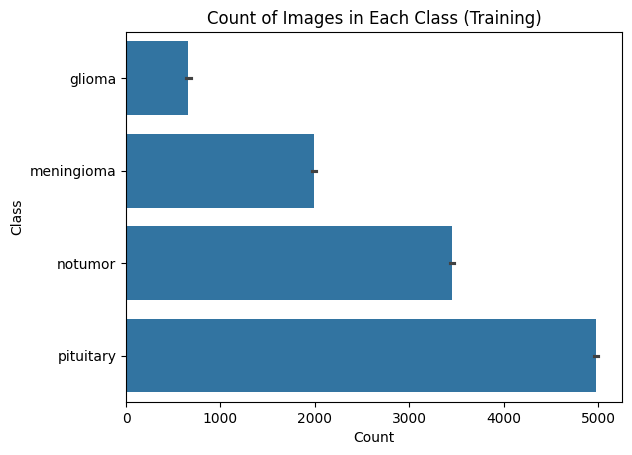

In [7]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

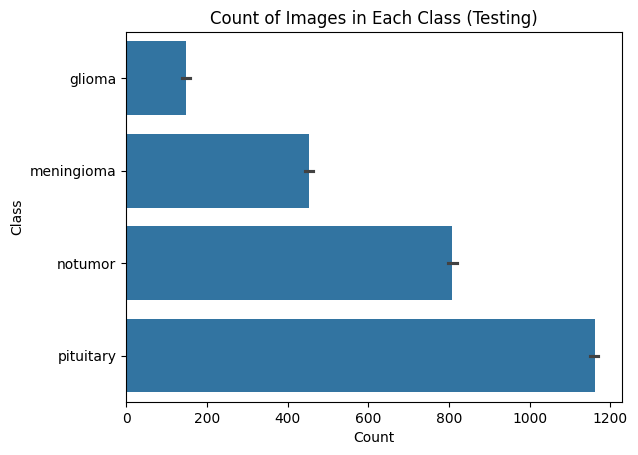

In [8]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

In [9]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [10]:
# Use annomoly detection, the notumor images to the tumor images. Could tell us where the tumor is.

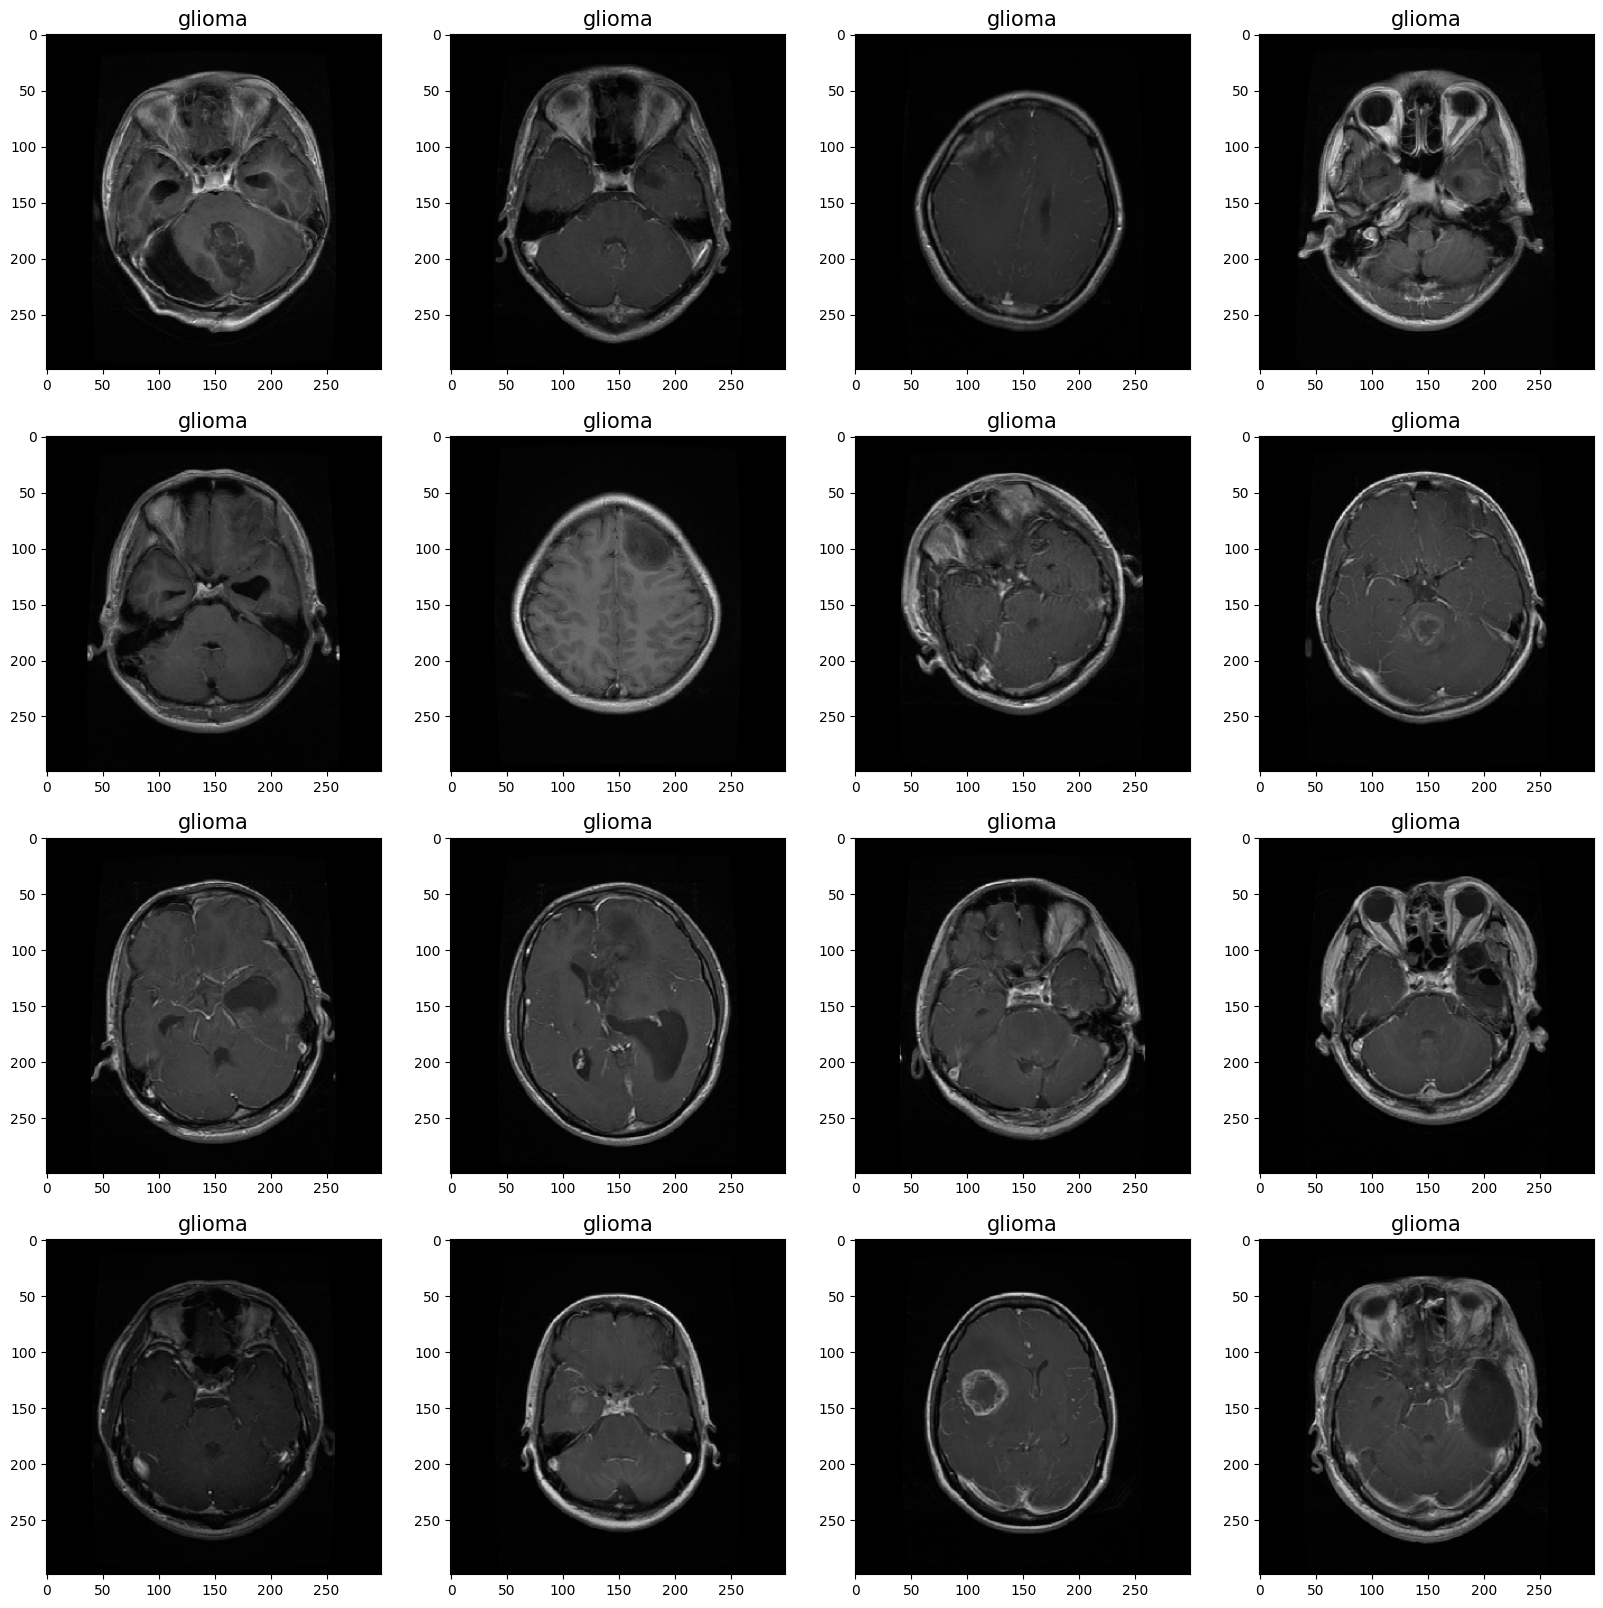

In [11]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

images = []
labels = []

for i in range(3):
    batch_images, batch_labels = next(ts_gen)
    images.extend(batch_images)
    labels.extend(batch_labels)

images = np.array(images)
labels = np.array(labels)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    if i >= 40: break 
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

#### Initial CNN

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 685ms/step - accuracy: 0.5877 - loss: 1.8267
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.8262 - loss: 0.4517
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 228ms/step - accuracy: 0.9296 - loss: 0.1999
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9716 - loss: 0.0901
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9874 - loss: 0.0449
82/82 - 24s - 289ms/step - accuracy: 0.9268 - loss: 0.2158
Loss: 0.21579355001449585
Accuracy: 0.9267734289169312


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


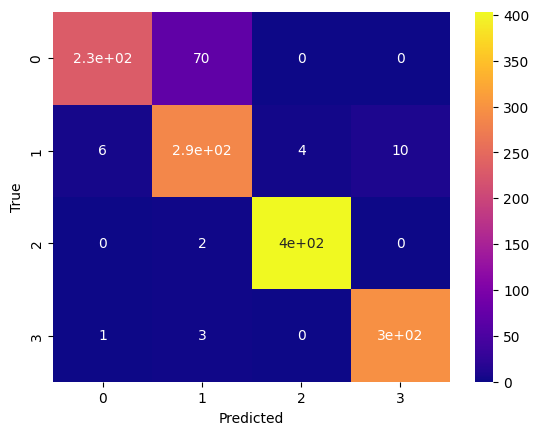

              precision    recall  f1-score   support

      glioma       0.97      0.77      0.86       300
  meningioma       0.79      0.93      0.86       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



In [13]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


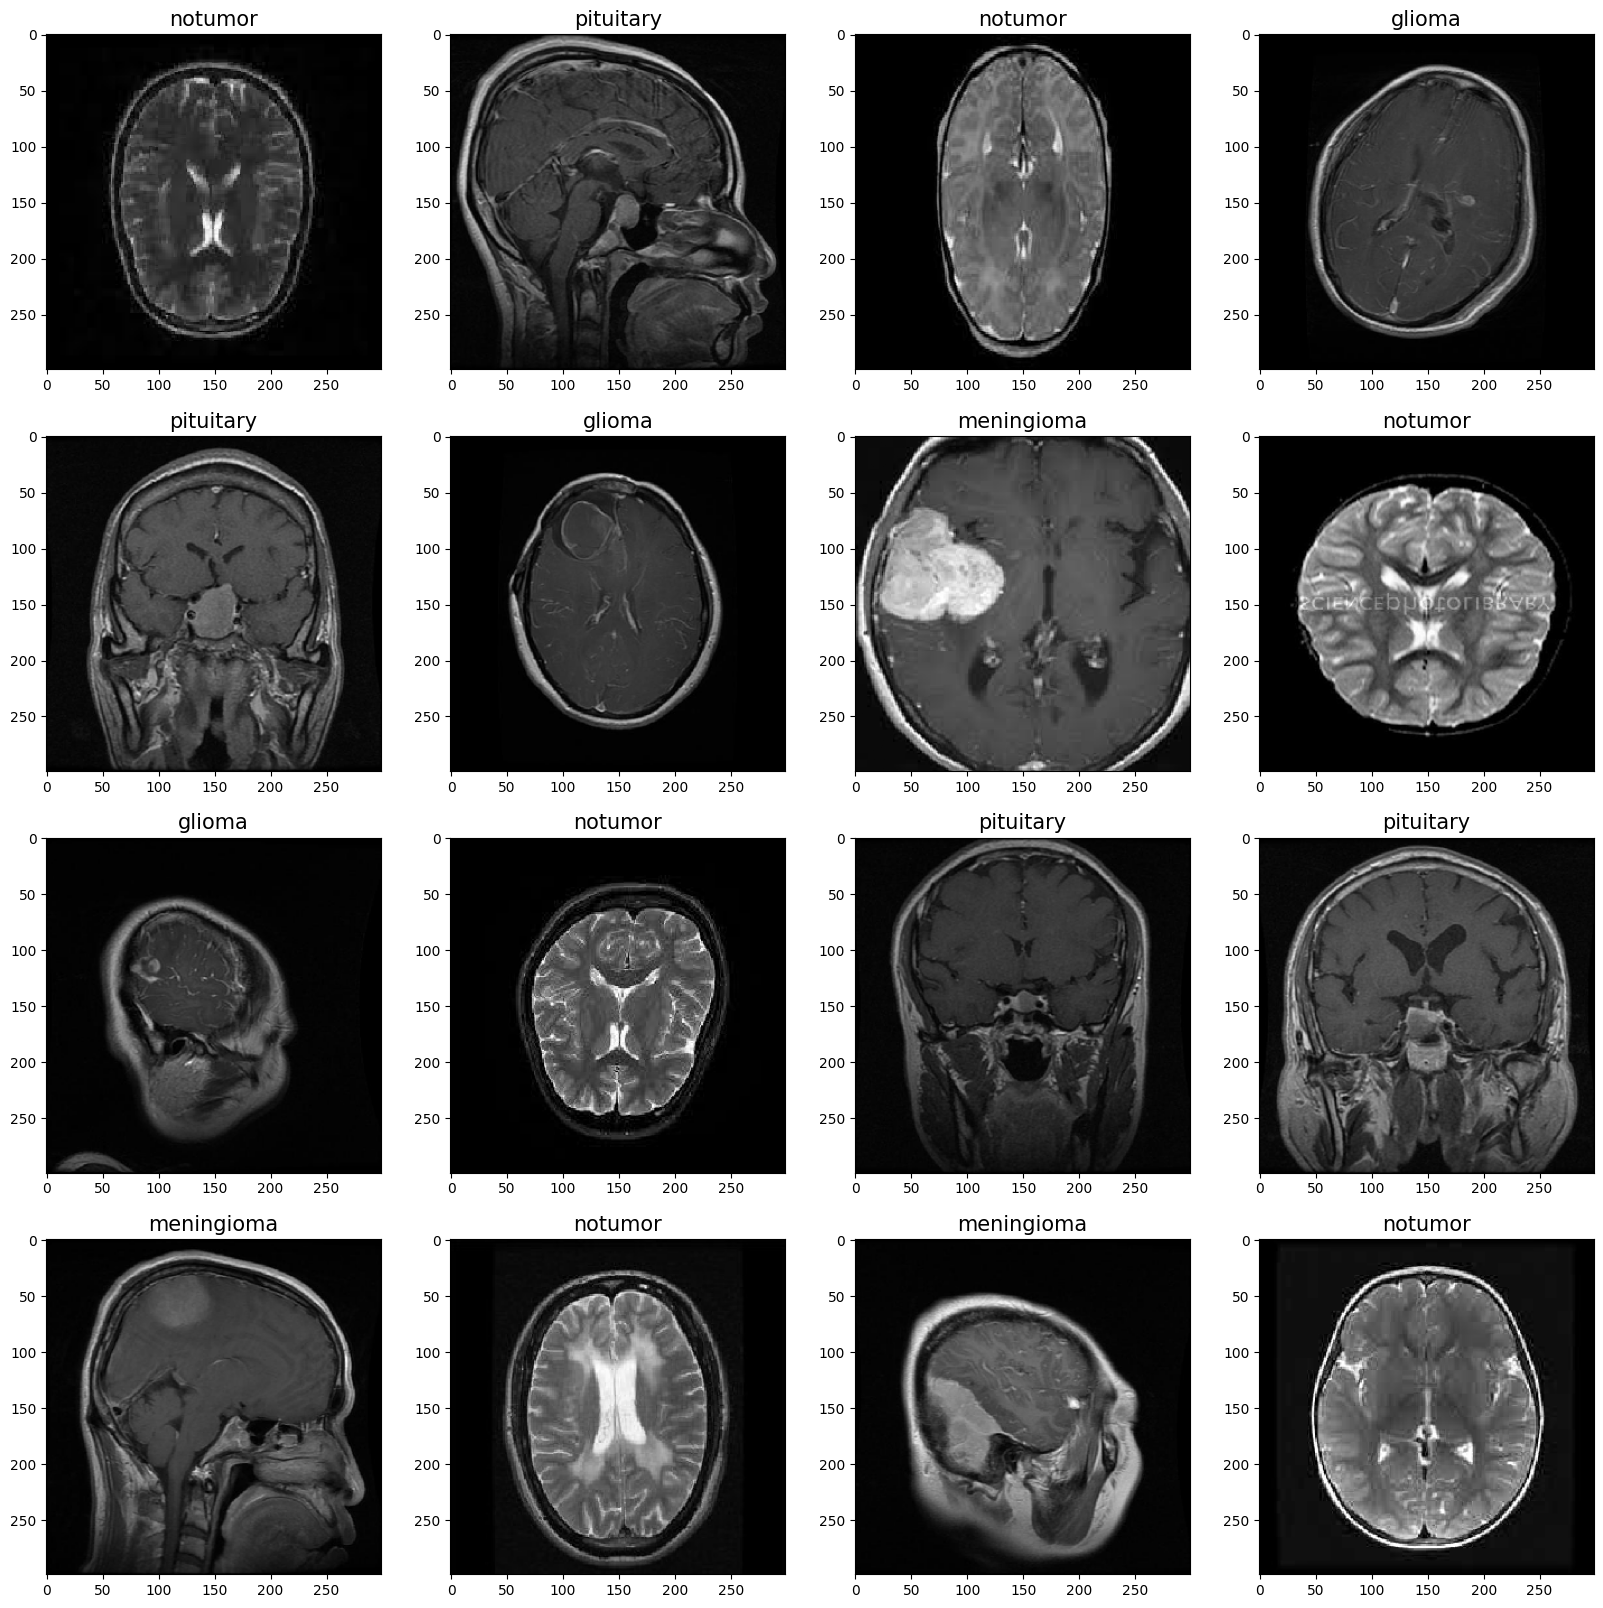

In [20]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,shuffle=True)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=True)

class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

In [21]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

Epoch 1/5


C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - accuracy: 0.7715 - loss: 1.6567
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - accuracy: 0.9338 - loss: 0.1924
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 241ms/step - accuracy: 0.9834 - loss: 0.0651
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 240ms/step - accuracy: 0.9953 - loss: 0.0252
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - accuracy: 0.9989 - loss: 0.0123
82/82 - 5s - 58ms/step - accuracy: 0.9458 - loss: 0.1964
Loss: 0.19635866582393646
Accuracy: 0.9458428621292114


82/82 - 4s - 53ms/step - accuracy: 0.9458 - loss: 0.1964
0.9458428621292114
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
0.2570556826849733
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

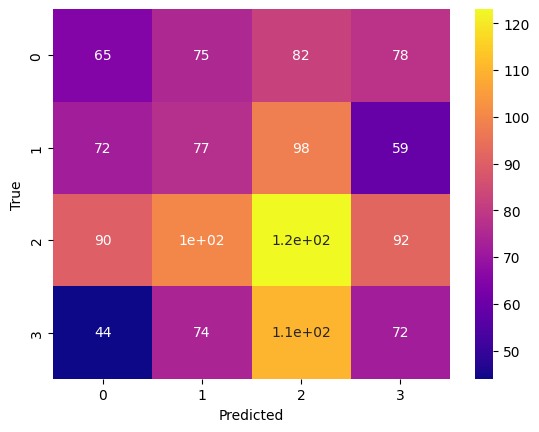

              precision    recall  f1-score   support

      glioma       0.24      0.22      0.23       300
  meningioma       0.24      0.25      0.24       306
     notumor       0.30      0.30      0.30       405
   pituitary       0.24      0.24      0.24       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.26      0.26      0.26      1311



In [ ]:
results = model.evaluate(ts_gen, verbose=2)
print(test_acc)
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
print(np.mean(y_pred==true_y_true))
print(y_true)
cm = confusion_matrix(true_y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

In [31]:
results

[0.19635868072509766, 0.9458428621292114]

In [39]:
true_y_true = []
for i, (images, labels) in enumerate(ts_gen):
    for label in labels:
        true_y_true.append(np.argmax(label,axis=-1))

KeyboardInterrupt: 